# Exercise 2. Build a better reduce.

In this example, you will use `dask.delayed` and `dask.visualize` to investigate the task graph for Python's built-in `reduce` function. You will then make your own `reduce` function with logic that is (hopefully) more parallelizable. Lastly, you'll compare the parallel execution times of your reduce function with the built-in reduce to see if it worked. :)

The reduce function, located in the built-in `functools` package, applies a function to a list to produce a single output. The function must take two inputs, and it is successively applied to pairs in the input list until the final output is reached. For example, if you want to apply an `add` function to a list of integers, reduce will first apply `add` to the first two elements of the list. It will then apply `add` to that result and the third element in the list. It will then apply `add` to that result and the fourth element in the list. And so on, as shown in the following diagram.

![reducediagram](figures/reduce.png)


## Step 1: Define function and inputs

This is the function that we will call reduce upon. Just an add function with a bit of a computational delay.

In [1]:
def add(x, y):
    n = 1e7
    while n>0:
        n -= 1  # make it kind of interesting ;)
    return x + y
inputs = range(8)  # let's add integers up to/including 7

## Step 2: Reduce syntax without delay

To help you get started, here is how reduce is called without any delayed function or dask magic.

In [2]:
from functools import reduce

In [3]:
%%time
from functools import reduce

z = reduce(add, inputs)
z

Wall time: 5.1 s


28

## Step 3: Delay add, apply reduce

In the subsequent cell, delay the `add` function and apply reduce on it (very similar to what we did for `map`).  
* What is the type of the output object?
* What does the task graph look like? Does it make sense? (**Hint**: use the keyword argument `rankdir='LR'` to show your task graph from left to right instead of top to bottom.)
* How long does this workflow take to execute? (Use default scheduler; i.e., `z.compute()` is fine.)

In [4]:
from dask import delayed

del_add = delayed(add)

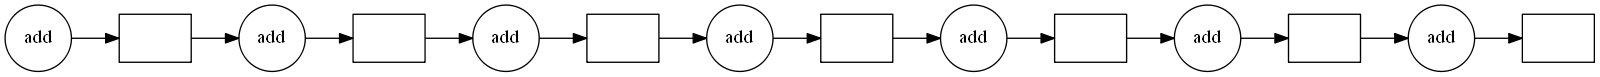

In [5]:
z = reduce(del_add, inputs)
z.visualize(rankdir='LR')

In [6]:
%%time
z.compute()

Wall time: 4.62 s


28

## Step 4: Build a better reduce

Add logic to `2_problem.py` so that your `myreduce` function can be parallizeable. Load it in using the cell below, then check the task graphs and execution times. Did it work?

In [7]:
# %load 2_solution.py
def myreduce(func, inplist):
    """A parallelizable reduce function"""
    if len(inplist) == 1:  # if one item, return it
        return inplist[0]
    elif len(inplist) == 2:  # if two items, call the function
        return func(*inplist)
    else:
        res_first = myreduce(func, inplist[:len(inplist) //2])  # recur reduce on first half
        res_second = myreduce(func, inplist[len(inplist) //2:])  # recur reduce on second half
        return func(res_first, res_second)
 

## Step 5: Check your task graphs, execution

Apply your `myreduce` function to the delayed `add` function. Look at the task graph. Does it look more parallelizable? Run the computation. Is it faster?

**Hint!** If your code is not faster but your task graph looks good, be sure you've fed the correct scheduler option into `compute`. :)

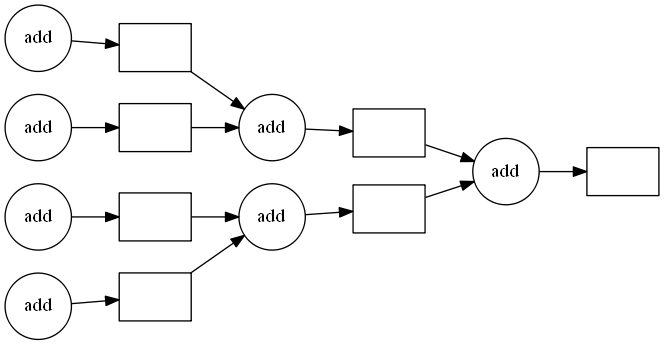

In [8]:
z = myreduce(del_add, inputs)
z.visualize(rankdir='LR')

In [9]:
%%time
z.compute()

Wall time: 4.62 s


28

In [10]:
%%time
z.compute(scheduler='processes')

Wall time: 3.87 s


28

**Conclusion**: It runs faster! Yay!